# Modello di Poisson (1) {#sec-stan-poisson-model-1}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import logging
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

In [2]:
seed: int = sum(map(ord, "stan_poisson_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduction {.unnumbered}

Nel @sec-gamma-poisson-model, abbiamo determinato la distribuzione a posteriori sia attraverso il metodo basato su griglia, sia tramite la derivazione analitica utilizzando la famiglia coniugata gamma-poisson. In questo capitolo, affronteremo lo stesso problema utilizzando Stan.

## Dati

Riconsideriamo lo stesso problema discusso nella sezione @sec-poisson-model. I dati disponibili sono:

In [3]:
y = np.array([2, 1, 3, 2, 2, 1, 1, 1])

## Modello di Poisson con Stan

Nel modello Stan utilizzeremo una verosimiglianza di Poisson e una distribuzione a priori per il parametro $\lambda$ modellata da una distribuzione Gamma con parametri $\alpha_{\text{prior}} = 9$ e $\beta_{\text{prior}} = 2$. 

In [10]:
stan_file = os.path.join(project_directory, "stan", "gamma_poisson_mcmc.stan")
model = CmdStanModel(stan_file=stan_file)

In [11]:
print(model.code())

data {
  int<lower=0> N; // numero di osservazioni
  array[N] int<lower=0> y; // dati osservati
  real<lower=0> alpha_prior; // parametro alpha della priori Gamma
  real<lower=0> beta_prior; // parametro beta della priori Gamma
}
parameters {
  real<lower=0> lambda; // parametro di interesse
}
model {
  // Priori
  lambda ~ gamma(alpha_prior, beta_prior);
  
  // Verosimiglianza
  y ~ poisson(lambda);
}
generated quantities {
  real alpha_post = alpha_prior + sum(y);
  real beta_post = beta_prior + N;
}



Sistemiamo i dati nel formato richiesto da Stan.

In [12]:
N = len(y)
alpha_prior = 9
beta_prior = 2

# Preparazione dei dati per Stan
stan_data = {"N": N, "y": y, "alpha_prior": alpha_prior, "beta_prior": beta_prior}
print(stan_data)

{'N': 8, 'y': array([2, 1, 3, 2, 2, 1, 1, 1]), 'alpha_prior': 9, 'beta_prior': 2}


Eseguiamo il campionamento.

In [14]:
fit = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Estraiamo un campione casuale dalla distribuzione a posteriori di `lambda`.

In [15]:
lambda_samples = fit.stan_variable("lambda")

Calcoliamo i parametri della Gamma a posteriori teorica.

In [16]:
alpha_post = alpha_prior + np.sum(y)
beta_post = beta_prior + N

Creiamo un istogramma con i campioni della distribuzione a posteriori di $\lambda$ e sovrapposta la densità teorica della distribuzione a posteriori.

Text(0.95, 0.95, 'alpha_post = 22.00\nbeta_post = 10.00')

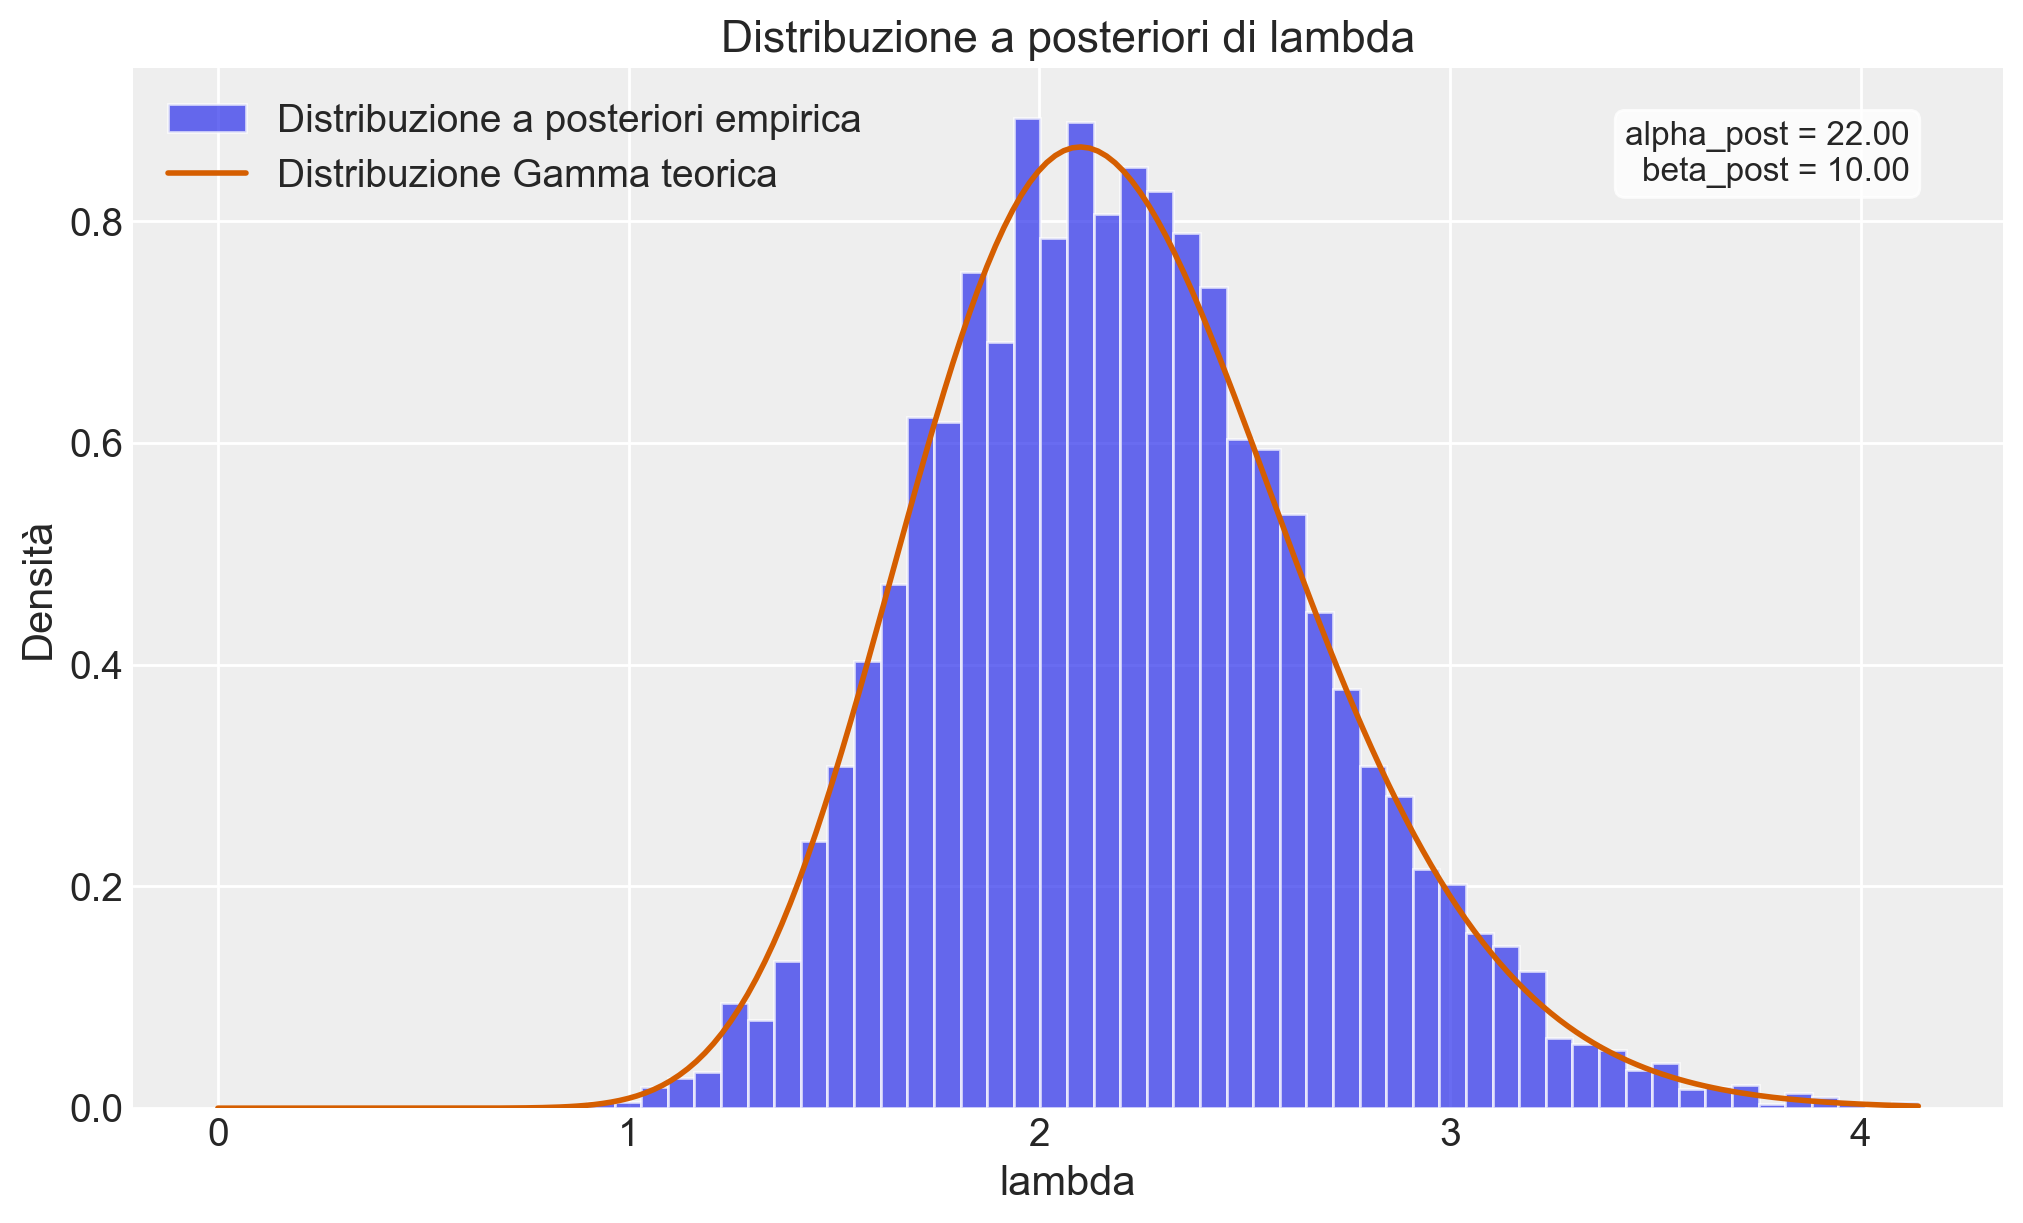

In [24]:
plt.figure(figsize=(10, 6))

# Istogramma normalizzato dei campioni MCMC
plt.hist(
    lambda_samples,
    bins=50,
    density=True,
    alpha=0.7,
    label="Distribuzione a posteriori empirica",
)

# Gamma teorica
x = np.linspace(0, max(lambda_samples), 200)
gamma_pdf = stats.gamma.pdf(x, a=alpha_post, scale=1 / beta_post)
plt.plot(x, gamma_pdf, "r-", lw=2, label="Distribuzione Gamma teorica")

# Personalizzazione del grafico
plt.title("Distribuzione a posteriori di lambda")
plt.xlabel("lambda")
plt.ylabel("Densità")
plt.legend()

# Aggiungiamo informazioni sui parametri
plt.text(
    0.95,
    0.95,
    f"alpha_post = {alpha_post:.2f}\nbeta_post = {beta_post:.2f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

Usiamo ArviZ per un sommario della distribuzione a posteriori del parametro $\lambda$.

In [21]:
az.summary(fit, var_names="lambda")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,2.214,0.467,1.395,3.11,0.008,0.006,3262.0,4279.0,1.0


Generiamo l'intervallo di credibilità al 94% per la distribuzione a posteriori del parametro `lambda`.

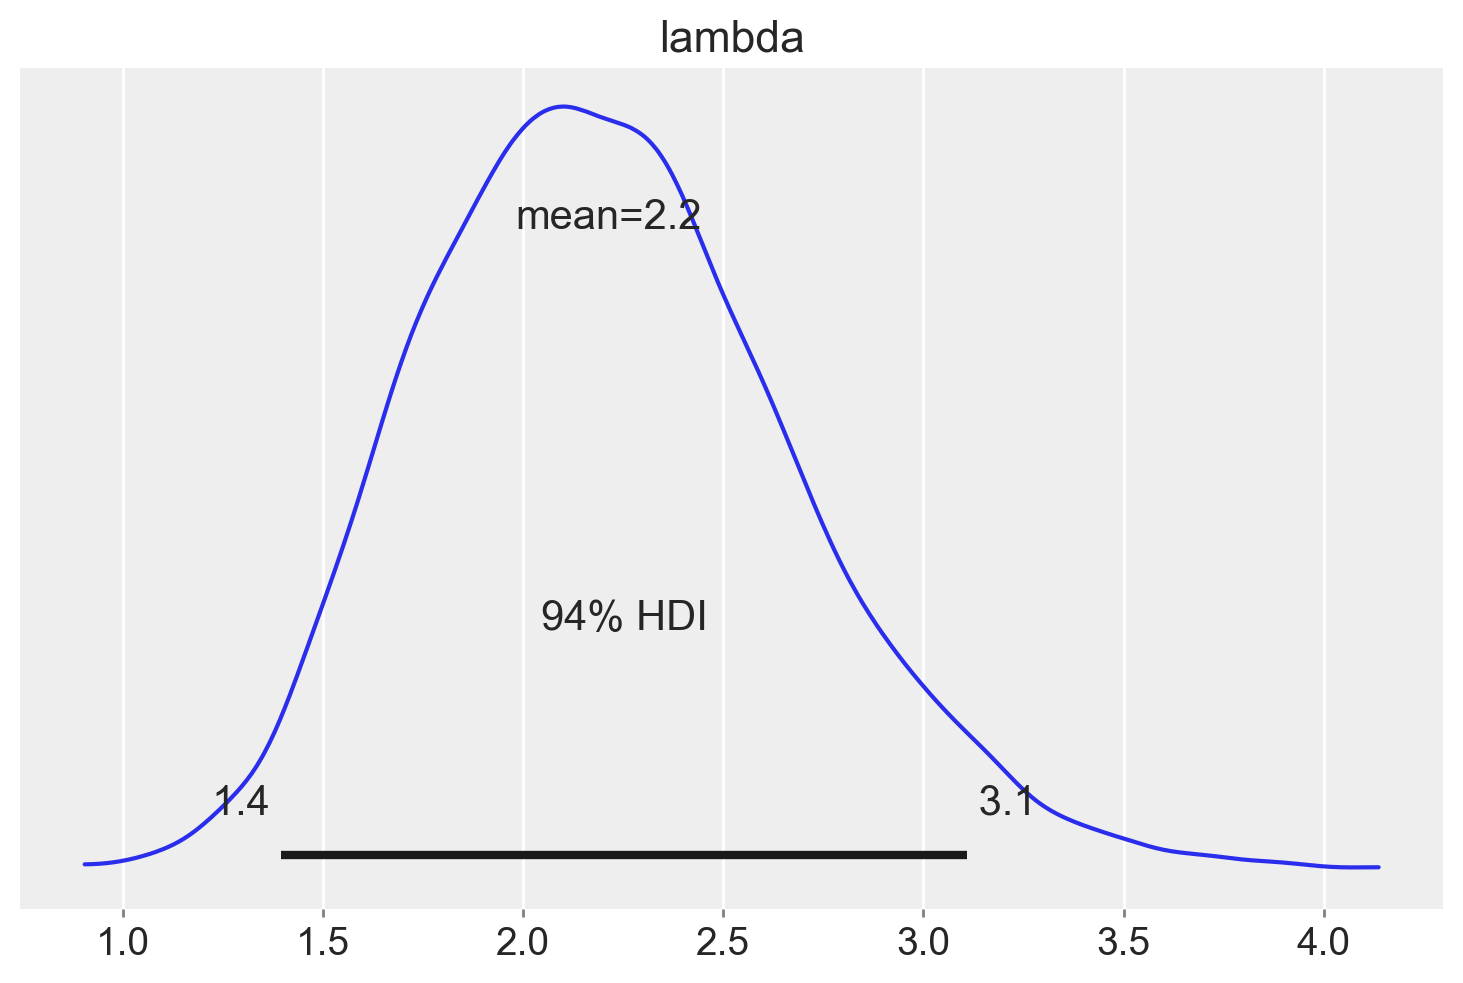

In [22]:
az.plot_posterior(fit, var_names="lambda")
plt.show()

In sintesi, analizzando i dati disponibili e utilizzando una distribuzione a priori Gamma(9, 2), possiamo affermare con un grado di certezza soggettivo del 94% che il tasso stimato di occorrenza dell'evento considerato sia di 2.2 compulsioni all'ora, con un intervallo di credibilità compreso tra 1.4 e 3.1.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -m 

Last updated: Fri Aug 16 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
arviz     : 0.18.0
scipy     : 1.14.0
logging   : 0.5.1.2
seaborn   : 0.13.2
numpy     : 1.26.4
matplotlib: 3.9.1
cmdstanpy : 1.2.4

